In [ ]:

#  Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipaddress
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

sns.set(style="whitegrid")


In [ ]:
#  STEP 1: Load the data

# Upload CSVs via Colab uploader or read from a mounted drive
fraud_df = pd.read_csv("Fraud_Data.csv")
ip_df = pd.read_csv("IpAddress_to_Country.csv")

# Preview
fraud_df.head()


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [ ]:
#  STEP 2: Initial Data Inspection

print(" Fraud Dataset Info:")
fraud_df.info()

print("\n Missing Values:\n", fraud_df.isnull().sum())

print("\n Class Distribution:")
print(fraud_df['class'].value_counts(normalize=True))


🧾 Fraud Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB

🔍 Missing Values:
 user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_add

In [ ]:
#  STEP 3: Data Cleaning

# Drop duplicates if any
fraud_df.drop_duplicates(inplace=True)

# Convert datetime columns
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])

# Sanity check
fraud_df.dtypes


,0
user_id,int64
signup_time,datetime64[ns]
purchase_time,datetime64[ns]
purchase_value,int64
device_id,object
source,object
browser,object
sex,object
age,int64
ip_address,float64


In [ ]:
#  STEP 4: Feature Engineering

# 1. Time since signup (in hours)
fraud_df['time_since_signup'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds() / 3600

# 2. Hour of purchase
fraud_df['hour_of_day'] = fraud_df['purchase_time'].dt.hour

# 3. Day of week
fraud_df['day_of_week'] = fraud_df['purchase_time'].dt.dayofweek

# 4. Transaction frequency per user
user_tx_counts = fraud_df.groupby('user_id')['purchase_time'].count()
fraud_df['user_tx_count'] = fraud_df['user_id'].map(user_tx_counts)

fraud_df[['time_since_signup', 'hour_of_day', 'day_of_week', 'user_tx_count']].describe()


,time_since_signup,hour_of_day,day_of_week,user_tx_count
count,151112.000000,151112.000000,151112.000000,151112.0
mean,1370.008125,11.521593,3.011819,1.0
std,868.406422,6.912474,2.006203,0.0
min,0.000278,0.000000,0.000000,1.0
25%,607.431528,6.000000,1.000000,1.0
50%,1368.429306,12.000000,3.000000,1.0
75%,2123.479028,17.000000,5.000000,1.0
max,2879.992222,23.000000,6.000000,1.0


In [ ]:
#  STEP 5: IP Address → Country Mapping (Fixed for numeric IPs)

# Convert IP columns to integers (if they were read as float)
fraud_df['ip_int'] = fraud_df['ip_address'].astype(float).astype(int)
ip_df['lower_bound_ip_int'] = ip_df['lower_bound_ip_address'].astype(float).astype(int)
ip_df['upper_bound_ip_int'] = ip_df['upper_bound_ip_address'].astype(float).astype(int)

# Map IP to Country by checking IP falls within range
def map_country(ip):
    match = ip_df[(ip_df['lower_bound_ip_int'] <= ip) & (ip_df['upper_bound_ip_int'] >= ip)]
    if not match.empty:
        return match.iloc[0]['country']
    return 'Unknown'

# Apply the mapping to fraud data
fraud_df['country'] = fraud_df['ip_int'].apply(map_country)

# Show result
fraud_df[['ip_address', 'country']].head()


,ip_address,country
0,7.327584e+08,Japan
1,3.503114e+08,United States
2,2.621474e+09,United States
3,3.840542e+09,Unknown
4,4.155831e+08,United States


In [ ]:
#  STEP 6: Handle Class Imbalance (Fixed)

# Extract features and label
X = fraud_df.drop(columns=['class', 'purchase_time', 'signup_time', 'ip_address', 'ip_int'])
y = fraud_df['class']

# Split before resampling (VERY IMPORTANT!)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Explicitly define columns
categorical = ['browser', 'source', 'sex', 'country']
# Only include truly numeric columns
numerical = ['purchase_value', 'age', 'time_since_signup', 'hour_of_day', 'day_of_week']

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
])

# Apply preprocessing
X_train_proc = preprocessor.fit_transform(X_train)

# Apply SMOTE (oversampling minority class)
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train_proc, y_train)

print("✅ Resampled class distribution:", dict(pd.Series(y_train_bal).value_counts()))


✅ Resampled class distribution: {0: np.int64(109568), 1: np.int64(109568)}


In [ ]:
#  STEP 7: Final Feature Matrix Check

# Apply same preprocessing to test set
X_test_proc = preprocessor.transform(X_test)

print(f"X_train_bal shape: {X_train_bal.shape}")
print(f"X_test_proc shape: {X_test_proc.shape}")


X_train_bal shape: (219136, 195)
X_test_proc shape: (30223, 195)


/tmp/ipython-input-11-1239152419.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=fraud_df, x='class', palette='Set2')


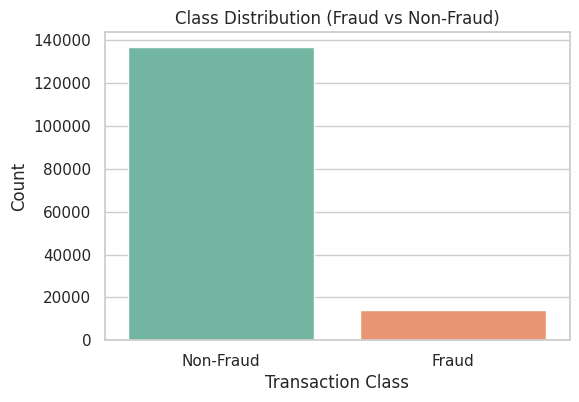

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(data=fraud_df, x='class', palette='Set2')
plt.title('Class Distribution (Fraud vs Non-Fraud)')
plt.xlabel('Transaction Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.show()


/tmp/ipython-input-12-4190381395.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=fraud_df, x='class', y='purchase_value', palette='Set3')


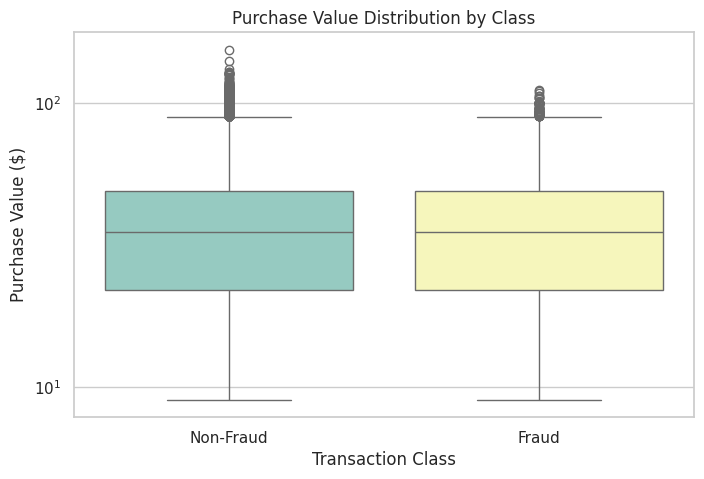

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=fraud_df, x='class', y='purchase_value', palette='Set3')
plt.title('Purchase Value Distribution by Class')
plt.xlabel('Transaction Class')
plt.ylabel('Purchase Value ($)')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.yscale('log')  # Helps if there are large outliers
plt.show()


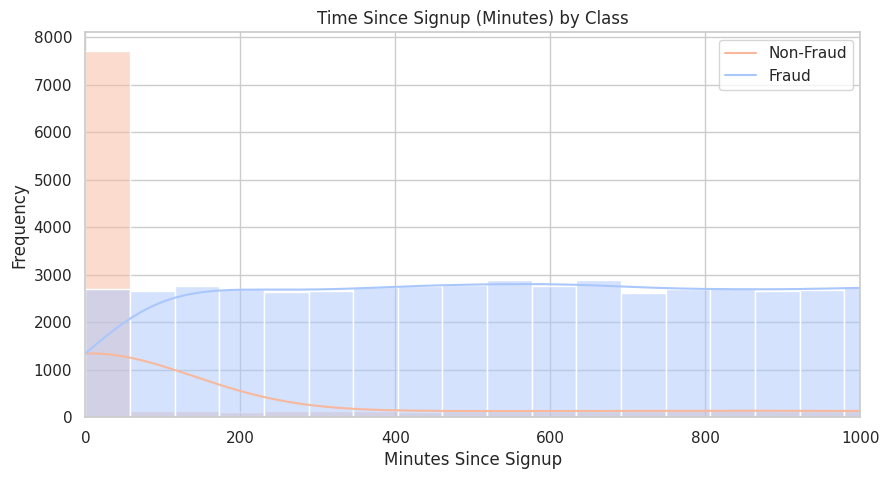

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(data=fraud_df, x='time_since_signup', hue='class', bins=50, kde=True, palette='coolwarm')
plt.title('Time Since Signup (Minutes) by Class')
plt.xlabel('Minutes Since Signup')
plt.ylabel('Frequency')
plt.legend(labels=['Non-Fraud', 'Fraud'])
plt.xlim(0, 1000)  # Optional: limit x-axis for readability
plt.show()


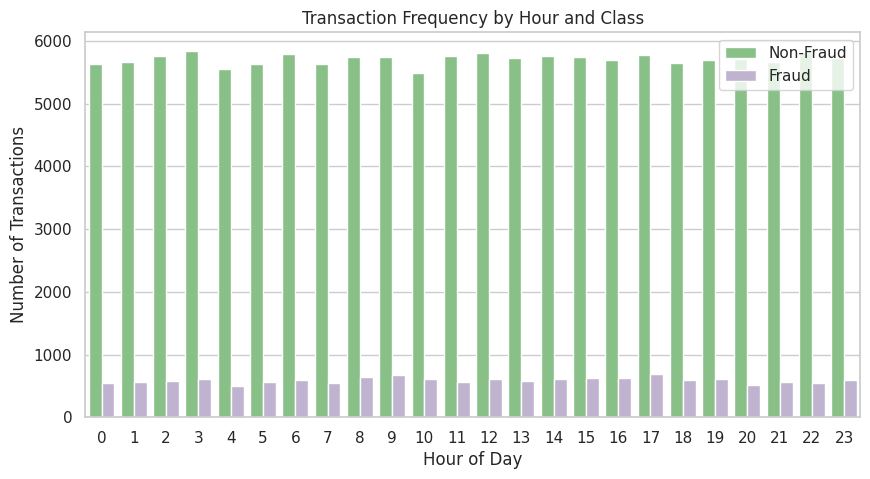

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(data=fraud_df, x='hour_of_day', hue='class', palette='Accent')
plt.title('Transaction Frequency by Hour and Class')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Transactions')
plt.legend(labels=['Non-Fraud', 'Fraud'])
plt.show()


/tmp/ipython-input-15-332650105.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.values, y=top_countries.index, palette='viridis')


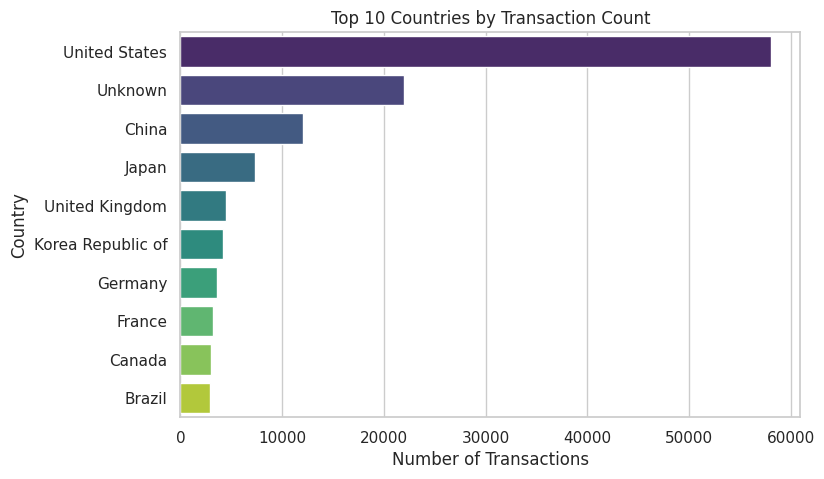

In [ ]:
top_countries = fraud_df['country'].value_counts().head(10)

plt.figure(figsize=(8, 5))
sns.barplot(x=top_countries.values, y=top_countries.index, palette='viridis')
plt.title('Top 10 Countries by Transaction Count')
plt.xlabel('Number of Transactions')
plt.ylabel('Country')
plt.show()
